# Autoencoders

## Undercomplete Autoencoders

Eerst gaan we oefenenen op het opstellen van een undercomplete Autoencoders
Deze gaat bijvoorbeeld gebruikt kunnen worden om dimensionality reduction uit te kunnen voeren.
Hiervoor maken we gebruik van de Fashion MNIST dataset die standaard in tensorflow aanwezig is.
De code uit deze notebook is gebaseerd op [de tutorial over autoencoders](https://www.tensorflow.org/tutorials/generative/autoencoder) op de site van tensorflow.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [10]:
bottleneck_size = 128

# geen extra hidden layers in het neuraal netwerk
# dit kan eventueel aangepast worden naar een convolutioneel neuraal netwerk
encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(bottleneck_size, activation='relu'),
])

# 784 is 28x28 -> dit is belangrijk anders gaat de reshape niet werken
decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),        # sigmoid geeft altijd waarden tussen 0 en 1 -> pixelwaarden zitten tussen 0 en 1
      layers.Reshape((28, 28))
])

autoencoder = tf.keras.Sequential([
    encoder,
    decoder
])

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [11]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))       # x train is zowel input als output

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0194 - val_loss: 0.0104
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0088 - val_loss: 0.0078
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0072 - val_loss: 0.0068
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0059 - val_loss: 0.0061
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.005

In [12]:
encoded_imgs = encoder(x_test).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

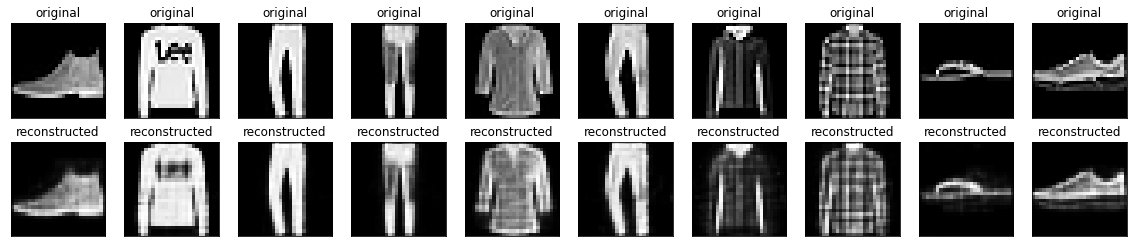

In [13]:
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Hoeveel dimensies/neuronen heb je nodig in de bottleneck om nog steeds een goed resultaat te krijgen.
Dit kan je bepalen met de elbow-methode waar je het aantal dimensies/neuronen in de bottleneck laat toenemen en wanneer de validation loss te groot wordt/snel begint te stijgen kan je stoppen.
Het aantal dimensies op het punt dat je stopt is dan het aantal dimensies dat je overhoudt.
Doe dit nu voor de voorgaande auto-encoder

Tried 1 latent dimensions resulting in a loss of 0.06336704641580582
Tried 51 latent dimensions resulting in a loss of 0.010624103248119354
Tried 101 latent dimensions resulting in a loss of 0.0075981407426297665
Tried 151 latent dimensions resulting in a loss of 0.006036106497049332
Tried 201 latent dimensions resulting in a loss of 0.004997211042791605
Tried 251 latent dimensions resulting in a loss of 0.004408011678606272
Tried 301 latent dimensions resulting in a loss of 0.0038520328234881163


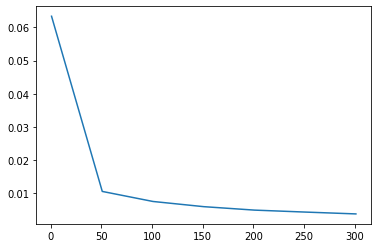

In [14]:
bottleneck_size = 64

# elbow methode -> bepalen hoeveel neuronen we willen als bottleneck

def get_encoder_model(bottleneck_size=1):
    encoder = tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(bottleneck_size, activation='relu'),
        ])

    decoder = tf.keras.Sequential([
        layers.Dense(784, activation='sigmoid'),
        layers.Reshape((28, 28))
        ])

    autoencoder = tf.keras.Sequential([
        encoder,
        decoder
    ])

    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

    return autoencoder

dims = range(1, 351, 50)
results = []
for x in dims:
    autoencoder = get_encoder_model(x)
    history = autoencoder.fit(x_train, x_train,
                epochs=5,
                shuffle=True,
                batch_size=64,
                verbose=0,
                validation_data=(x_test, x_test))

    loss = history.history["val_loss"][-1]
    results.append(loss)
    print(f"Tried {x} latent dimensions resulting in a loss of {loss}")

plt.plot(dims, results)

## Denoising autoencoder

In het volgende voorbeeld gaan we een autoencoder opstellen om ruis uit een figuur te gaan verwijderen.
We gebruiken hierbij dezelfde dataset als in het eerste voorbeeld.

Eerst gaan we ruis toevoegen aan de dataset.
Dit kan als volgt

In [3]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

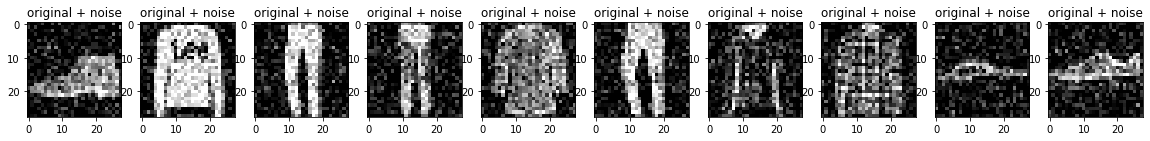

In [4]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

Stel nu een denoising autoencoder op die gebruik maakt van minstens 2 convolutionele lagen.

In [24]:
print(x_train[i].shape)
print(tf.expand_dims(x_train[i], 0).shape)      # 0 is waar de extra dimensie moet toegevoegd worden (in dit geval in het begin)

(28, 28)
(1, 28, 28)


In [30]:
bottleneck_size = 64

# encoder -> noise image to bottleneck
encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
      layers.MaxPool2D(),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
      layers.MaxPool2D(),
      layers.Flatten(),
      layers.Dense(bottleneck_size, activation="relu")
])

test_img = encoder(tf.expand_dims(x_train[i],0))     # na maxpool2d is de shape (7,7,8) -> 400 tal waarden -> 64 is nog een bottleneck


# decoder
decoder = tf.keras.Sequential([
      layers.Dense(392, activation="relu"),
      layers.Reshape((7,7,8)),
      layers.UpSampling2D(),
      layers.Conv2DTranspose(16, kernel_size=(3,3), activation="relu", padding="same"),
      layers.UpSampling2D(),
      layers.Conv2DTranspose(1, kernel_size=(3,3), activation="relu", padding="same"),
])

decoder(test_img)

autoencoder = tf.keras.Sequential([
      encoder,
      decoder
])

autoencoder(tf.expand_dims(x_train[i],0))  

<tf.Tensor: shape=(1, 28, 28, 1), dtype=float32, numpy=
array([[[[4.74198721e-02],
         [4.82018627e-02],
         [3.06413621e-02],
         [3.12916711e-02],
         [2.82723550e-02],
         [2.53209919e-02],
         [4.75546233e-02],
         [1.60189308e-02],
         [3.42019387e-02],
         [6.98464960e-02],
         [6.70012683e-02],
         [1.15164034e-01],
         [1.14406392e-01],
         [8.75569731e-02],
         [1.44743264e-01],
         [1.16776273e-01],
         [1.23222992e-01],
         [1.11832559e-01],
         [9.22341645e-02],
         [8.39774236e-02],
         [6.43047839e-02],
         [8.30084458e-02],
         [2.87410263e-02],
         [5.68182692e-02],
         [7.89682642e-02],
         [6.75678030e-02],
         [8.63109976e-02],
         [5.00260480e-02]],

        [[3.62383574e-02],
         [2.85118669e-02],
         [3.14236991e-02],
         [6.14554659e-02],
         [6.51762336e-02],
         [3.96874510e-02],
         [5.54960445e-02

In [34]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(x_train_noisy, x_train, epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0119 - val_loss: 0.0119
Epoch 2/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0116 - val_loss: 0.0116
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0115 - val_loss: 0.0115
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0114 - val_loss: 0.0116
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0112 - val_loss: 0.0113
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0111 - val_loss: 0.0113
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/10
1875/1875 [==============================] - 11s 6ms/step - l

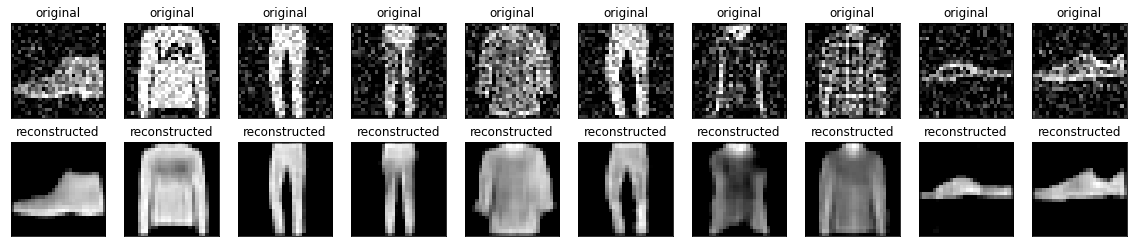

In [35]:
n = 10

encoded_imgs = encoder(x_test_noisy[:n]).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test_noisy[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()